In [8]:
import os
import sys

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

from jax import vmap
import jax.numpy as jnp
from jax.nn import sigmoid

CWD = os.path.abspath("")
sys.path.append(CWD)
sys.path.append(os.path.join(CWD, ".."))
from plt_settings import plt_settings

full_width = 5.5
ratio = 1 / 1.618

In [9]:
# Load data
from data.adult import get_data

(
    X,
    y,
    var_names,
    gender_idx,
    male_idx,
    female_idx,
    X_test,
    y_test,
    test_male_idx,
    test_female_idx,
) = get_data()

X_test_cf = X_test.at[:, gender_idx].set(1 - X_test[:, gender_idx])


def ineqconst(beta):
    return jnp.array(
        [
            100 * (sigmoid(jnp.dot(X, beta)).mean() - sigmoid(jnp.dot(X[male_idx, :], beta)).mean())
            - 1,
            100
            * (sigmoid(jnp.dot(X, beta)).mean() - sigmoid(jnp.dot(X[female_idx, :], beta)).mean())
            - 1,
        ]
    )


def report_acc_overall(beta):
    y_pred = jnp.where(jnp.dot(X_test, beta) < 0.0, 0.0, 1.0).astype(jnp.int32)
    print(classification_report(y_test, y_pred))
    return (y_pred == y_test).mean()


def prevalence(X, beta, male_idx, female_idx):
    y_pred = jnp.where(jnp.dot(X, beta) < 0.0, 0.0, 1.0)

    return jnp.array(
        [
            y_pred.mean(),
            y_pred[male_idx].mean(),
            y_pred[female_idx].mean(),
        ]
    )


def disparity(X, beta, male_idx, female_idx):
    prev = prevalence(X, beta, male_idx, female_idx)

    return jnp.array(
        [
            prev[1] - prev[0],
            prev[2] - prev[0],
        ]
    )


def prevalence_test(beta):
    return prevalence(X_test, beta, test_male_idx, test_female_idx)


def prevalence_train(beta):
    return prevalence(X, beta, male_idx, female_idx)


def disparity_test(beta):
    return disparity(X_test, beta, test_male_idx, test_female_idx)


def disparity_train(beta):
    return disparity(X, beta, male_idx, female_idx)

In [10]:
ITERATIONS = int(2e4)
BURN_IN = int(1e4)

sampling_data = np.load(os.path.join(CWD, "fairness.npz"))
lmc_samples = sampling_data["lmc_x"][BURN_IN:, :]
pdlmc_samples = sampling_data["pdlmc_x"][BURN_IN:, :]
pdlmc_lambda = sampling_data["pdlmc_lambda"]

pdlmc_samples_all = sampling_data["pdlmc_x"]
slacks = vmap(ineqconst)(pdlmc_samples_all)

lmc_prev = vmap(prevalence_test)(lmc_samples)
lmc_disp = vmap(disparity_test)(lmc_samples)
lmc_disp_train = vmap(disparity_train)(lmc_samples)
pdlmc_prev = vmap(prevalence_test)(pdlmc_samples)
pdlmc_disp = vmap(disparity_test)(pdlmc_samples)
pdlmc_disp_train = vmap(disparity_train)(pdlmc_samples)

print("rate of positive predictions (population, male, female)")
print(f"LMC: {lmc_prev.mean(axis=0)}")
print(f"PD-LMC: {pdlmc_prev.mean(axis=0)}")

rate of positive predictions (population, male, female)
LMC: [0.1910278  0.26130155 0.05024695]
PD-LMC: [0.17164388 0.18165837 0.15158165]


In [11]:
init_beta = np.random.normal(0.0, 1.0, (X.shape[1],)) * 0.1

_ = report_acc_overall(init_beta)

print("")
print("Disparity of average positive predictions per gender (male, female)")
print(f"At initialization (train): {disparity_train(init_beta)}")
print(f"At initialization (test):  {disparity_test(init_beta)}")

lmc_acc = report_acc_overall(lmc_samples.mean(axis=0))
print("LMC (train):", lmc_disp_train.mean(axis=0))
print("LMC (test):", lmc_disp.mean(axis=0))

pdlmc_acc = report_acc_overall(pdlmc_samples.mean(axis=0))
print("PDLMC (train):", pdlmc_disp_train.mean(axis=0))
print("PDLMC (test):", pdlmc_disp.mean(axis=0))

              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68     12435
         1.0       0.20      0.29      0.24      3846

    accuracy                           0.55     16281
   macro avg       0.47      0.46      0.46     16281
weighted avg       0.61      0.55      0.58     16281


Disparity of average positive predictions per gender (male, female)
At initialization (train): [ 0.0213134  -0.04311752]
At initialization (test):  [ 0.02448288 -0.04904702]
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90     12435
         1.0       0.69      0.56      0.62      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.74      0.76     16281
weighted avg       0.83      0.84      0.83     16281

LMC (train): [ 0.07131939 -0.14428091]
LMC (test): [ 0.07027376 -0.14078087]
              precision    recall  f1-score   support

         0.0       0.85      0.93      

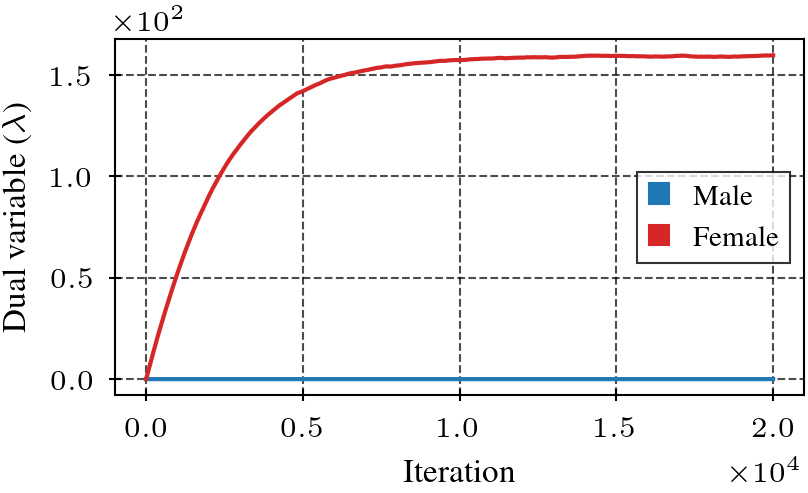

In [12]:
plt_settings["figure.figsize"] = (full_width / 2, ratio * full_width / 2)

with plt.rc_context(plt_settings):
    _, axs = plt.subplots(1, 1, dpi=300)
    axs.plot(pdlmc_lambda[:, 0], label="Male", c="C0")
    axs.plot(pdlmc_lambda[:, 1], label="Female", c="C3")
    axs.grid(True, linestyle='--', alpha=0.7)
    axs.set_xlabel("Iteration")
    axs.set_ylabel(r"Dual variable ($\lambda$)")
    axs.legend(
        [
            Rectangle((0, 0), 1, 1, color=f"C0", alpha=1.0),
            Rectangle((0, 0), 1, 1, color=f"C3", alpha=1.0),
        ],
        ["Male", "Female"],
        handlelength=0.7,
        # loc="lower right",
    )
    axs.ticklabel_format(scilimits=(0, 2))

    plt.show()

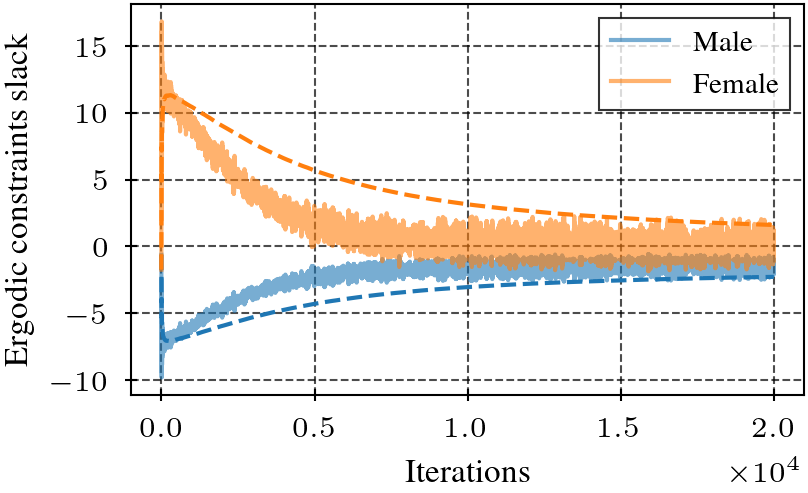

In [13]:
plt_settings["figure.figsize"] = (full_width / 2, ratio * full_width / 2)

cum_mean = np.cumsum(slacks, axis=0) / np.expand_dims(
    np.arange(1, len(pdlmc_samples_all) + 1), axis=1
)

with plt.rc_context(plt_settings):
    _, axs = plt.subplots(1, 1, dpi=300)
    axs.plot(slacks[:, 0], label="Male", color="C0", alpha=0.6)
    axs.plot(cum_mean[:, 0], linestyle="--", label=None, color="C0")
    axs.plot(slacks[:, 1], label="Female", color="C1", alpha=0.6)
    axs.plot(cum_mean[:, 1], linestyle="--", label=None, color="C1")
    axs.grid(True, linestyle='--', alpha=0.7)
    axs.set_xlabel("Iterations")
    axs.set_ylabel(r"Ergodic constraints slack")
    axs.ticklabel_format(scilimits=(0, 2))
    plt.legend()

    plt.show()

In [14]:
def prob_test(beta):
    return jnp.where(jnp.dot(X_test, beta) < 0, 0.0, 1.0)


lmc_p = vmap(prob_test)(lmc_samples)
pdlmc_p = vmap(prob_test)(pdlmc_samples)

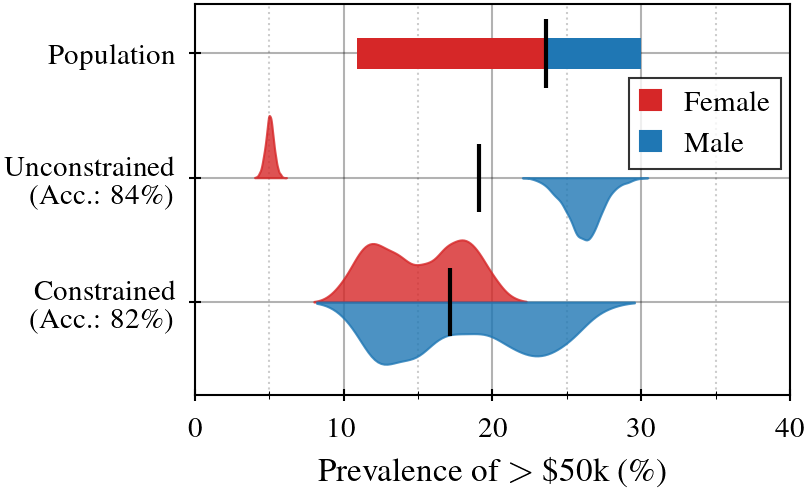

In [15]:
plt_settings["figure.figsize"] = (full_width / 2, ratio * full_width / 2)
width = 0.25


def bar_prev(ax, y, disp_female, disp_male, mean, labels=(None, None)):
    ax.barh(y, disp_female, width, left=mean, color="C3", label=labels[0])
    ax.barh(y, disp_male, width, left=mean, color="C0", label=labels[1])
    ax.vlines(mean, y - 1.1 * width, y + 1.1 * width, color="black")


def violin_prev(ax, y, samples_f, samples_m):
    parts = ax.violinplot(
        dataset=samples_f,
        positions=[y],
        widths=1,
        showextrema=False,
        vert=False,
        side="high",
    )
    for pc in parts["bodies"]:
        pc.set_facecolor("C3")
        pc.set_edgecolor("C3")
        pc.set_alpha(0.8)

    parts = ax.violinplot(
        dataset=samples_m,
        positions=[y],
        widths=1,
        showextrema=False,
        vert=False,
        side="low",
    )
    for pc in parts["bodies"]:
        pc.set_facecolor("C0")
        pc.set_edgecolor("C0")
        pc.set_alpha(0.8)


with plt.rc_context(plt_settings):
    fig, ax = plt.subplots(1, 1, dpi=300)

    # Add major and minor grid for better readability of prevalence values
    ax.grid(True, which='major', linestyle='-', alpha=0.3)
    ax.grid(True, which='minor', linestyle=':', alpha=0.2)
    
    # Population statistics (actual data)
    bar_prev(
        ax,
        2,
        y_test[test_female_idx].mean() - y_test.mean(),
        y_test[test_male_idx].mean() - y_test.mean(),
        y_test.mean(),
        ("Female", "Male"),
    )
    
    # Unconstrained model predictions (LMC)
    violin_prev(
        ax,
        1,
        lmc_p[:, test_female_idx].mean(axis=1),
        lmc_p[:, test_male_idx].mean(axis=1),
    )
    ax.vlines(lmc_p.flatten().mean(), 1 - 1.1 * width, 1 + 1.1 * width, color="black")

    # Constrained model predictions (PD-LMC)
    violin_prev(
        ax,
        0,
        pdlmc_p[:, test_female_idx].mean(axis=1),
        pdlmc_p[:, test_male_idx].mean(axis=1),
    )
    ax.vlines(pdlmc_p.flatten().mean(), 0 - 1.1 * width, 0 + 1.1 * width, color="black")

    ax.set_xlabel(r"Prevalence of $>$ \$50k (\%)")
    ax.set_xticks(np.arange(0, 0.5, 0.1))
    ax.set_xticklabels(np.arange(0, 50, 10))
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(
        [
            f"Constrained\n(Acc.: {100*pdlmc_acc:.0f}\\%)",
            f"Unconstrained\n(Acc.: {100*lmc_acc:.0f}\\%)",
            "Population",
        ]
    )
    ax.set_ylim([-0.75, 2.4])
    
    # Add minor ticks for finer grid
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
    
    ax.legend(
        [
            Rectangle((0, 0), 1, 1, color=f"C3", alpha=1.0),
            Rectangle((0, 0), 1, 1, color=f"C0", alpha=1.0),
        ],
        ["Female", "Male"],
        handlelength=0.7,
        loc="lower right",
        bbox_to_anchor=(1.01, 0.54),
    )

    plt.show()

In [16]:
sampling_data_d = np.load(os.path.join(CWD, "fairness_relaxed.npz"))
deltas = [0.01, 0.02, 0.03, 0.04, 0.05]

pdlmc_samples_d = [
    sampling_data_d["pdlmc_x_1"][BURN_IN:, :],
    sampling_data_d["pdlmc_x_2"][BURN_IN:, :],
    sampling_data_d["pdlmc_x_3"][BURN_IN:, :],
    sampling_data_d["pdlmc_x_4"][BURN_IN:, :],
    sampling_data_d["pdlmc_x_5"][BURN_IN:, :],
]

pdlmc_lambda_d = [
    sampling_data_d["pdlmc_lambda_1"],
    sampling_data_d["pdlmc_lambda_2"],
    sampling_data_d["pdlmc_lambda_3"],
    sampling_data_d["pdlmc_lambda_4"],
    sampling_data_d["pdlmc_lambda_5"],
]

pdlmc_p_d = [vmap(prob_test)(samples) for samples in pdlmc_samples_d]

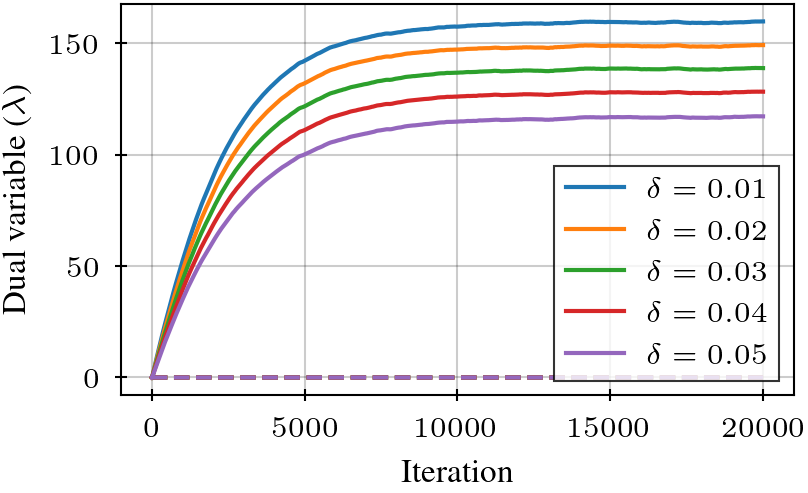

In [17]:
plt_settings["figure.figsize"] = (full_width / 2, ratio * full_width / 2)

with plt.rc_context(plt_settings):
    _, axs = plt.subplots(1, 1, dpi=300)
    for idx, lambdas in enumerate(pdlmc_lambda_d):
        axs.plot(lambdas[:, 0], "--", c=f"C{idx}", label=None)
        axs.plot(lambdas[:, 1], c=f"C{idx}", label=rf"$\delta = {deltas[idx]}$")
    axs.grid()
    axs.set_xlabel("Iteration")
    axs.set_ylabel(r"Dual variable ($\lambda$)")
    axs.legend(loc="lower right")

    plt.show()

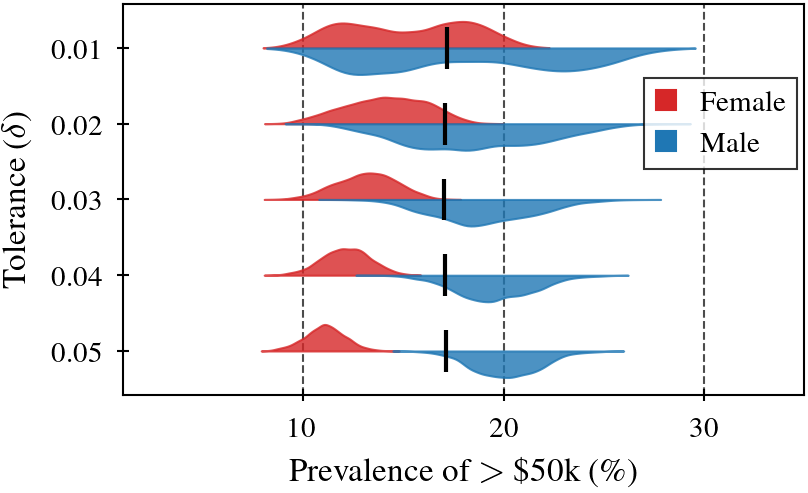

In [18]:
plt_settings["figure.figsize"] = (full_width / 2, ratio * full_width / 2)
width = 0.25


def violin_prev(ax, y, samples_f, samples_m):
    parts = ax.violinplot(
        dataset=samples_f,
        positions=[y],
        widths=0.7,
        showextrema=False,
        vert=False,
        side="high",
    )
    for pc in parts["bodies"]:
        pc.set_facecolor("C3")
        pc.set_edgecolor("C3")
        pc.set_alpha(0.8)

    parts = ax.violinplot(
        dataset=samples_m,
        positions=[y],
        widths=0.7,
        showextrema=False,
        vert=False,
        side="low",
    )
    for pc in parts["bodies"]:
        pc.set_facecolor("C0")
        pc.set_edgecolor("C0")
        pc.set_alpha(0.8)


with plt.rc_context(plt_settings):
    fig, ax = plt.subplots(1, 1, dpi=300)

    for idx, samples in enumerate(pdlmc_p_d):
        violin_prev(
            ax,
            -idx,
            samples[:, test_female_idx].mean(axis=1),
            samples[:, test_male_idx].mean(axis=1),
        )
        ax.vlines(samples.flatten().mean(), -idx - 1.1 * width, -idx + 1.1 * width, color="black")

    ax.set_xlabel(r"Prevalence of $>$ \$50k (\%)")
    ax.set_xticks(np.arange(0, 0.4, 0.1))
    ax.set_xticklabels(np.arange(0, 40, 10))
    ax.set_xlim(0.01, 0.35)
    ax.set_yticks(np.arange(0, -5, -1))
    ax.set_yticklabels([f"{d}" for d in deltas])
    ax.set_ylabel(r"Tolerance ($\delta$)")
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax.legend(
        [
            Rectangle((0, 0), 1, 1, color=f"C3", alpha=1.0),
            Rectangle((0, 0), 1, 1, color=f"C0", alpha=1.0),
        ],
        ["Female", "Male"],
        handlelength=0.7,
        loc="lower right",
        bbox_to_anchor=(1.01, 0.54),
    )

    plt.show()

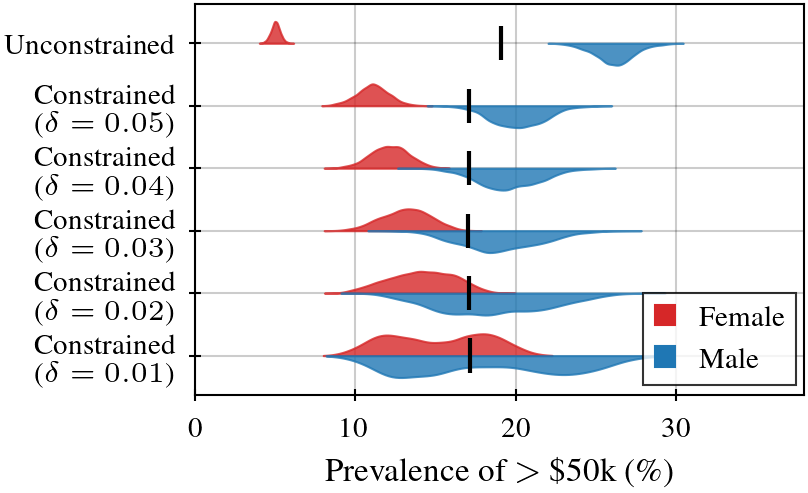

: 

In [ ]:
plt_settings["figure.figsize"] = (full_width / 2, ratio * full_width / 2)
width = 0.25


def violin_prev(ax, y, samples_f, samples_m):
    parts = ax.violinplot(
        dataset=samples_f,
        positions=[y],
        widths=0.7,
        showextrema=False,
        vert=False,
        side="high",
    )
    for pc in parts["bodies"]:
        pc.set_facecolor("C3")
        pc.set_edgecolor("C3")
        pc.set_alpha(0.8)

    parts = ax.violinplot(
        dataset=samples_m,
        positions=[y],
        widths=0.7,
        showextrema=False,
        vert=False,
        side="low",
    )
    for pc in parts["bodies"]:
        pc.set_facecolor("C0")
        pc.set_edgecolor("C0")
        pc.set_alpha(0.8)


with plt.rc_context(plt_settings):
    fig, ax = plt.subplots(1, 1, dpi=300)

    # Plot unconstrained at the top
    violin_prev(
        ax,
        len(deltas),
        lmc_p[:, test_female_idx].mean(axis=1),
        lmc_p[:, test_male_idx].mean(axis=1),
    )
    ax.vlines(lmc_p.flatten().mean(), len(deltas) - 1.1 * width, len(deltas) + 1.1 * width, color="black")

    # Plot all deltas
    for i, delta in enumerate(deltas):
        violin_prev(
            ax,
            i,
            pdlmc_p_d[i][:, test_female_idx].mean(axis=1),
            pdlmc_p_d[i][:, test_male_idx].mean(axis=1),
        )
        ax.vlines(pdlmc_p_d[i].flatten().mean(), i - 1.1 * width, i + 1.1 * width, color="black")

    ax.set_xlabel(r"Prevalence of $>$ \$50k (\%)")
    ax.set_xticks(np.arange(0, 0.4, 0.1))
    ax.set_xticklabels(np.arange(0, 40, 10))
    ax.set_xlim(0, 0.38)
    
    # Set y-ticks for all deltas plus unconstrained
    ax.set_yticks(range(len(deltas) + 1))
    labels = [f"Constrained\n($\\delta = {d}$)" for d in deltas]
    labels.append("Unconstrained")
    ax.set_yticklabels(labels)

    ax.grid()
    ax.legend(
        [
            Rectangle((0, 0), 1, 1, color=f"C3", alpha=1.0),
            Rectangle((0, 0), 1, 1, color=f"C0", alpha=1.0),
        ],
        ["Female", "Male"],
        handlelength=0.7,
        loc="lower right",
        bbox_to_anchor=(1.01, -0.01),
    )

    plt.show()

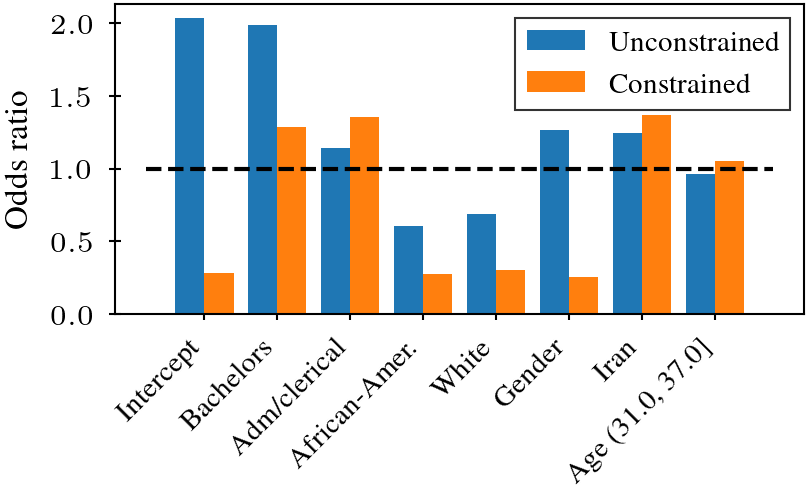

In [20]:
plt_settings["figure.figsize"] = (full_width / 2, ratio * full_width / 2)
width = 0.4
var_subset = [
    "Intercept",
    "education_Bachelors",
    "occupation_Adm-clerical",
    "race_Black",
    "race_White",
    "gender_Male",
    "native-country_Iran",
    "age_(31.0, 37.0]",
]

var_labels = np.append(["Intercept"], var_names.to_numpy())
coeff_unc = pd.DataFrame(np.exp(lmc_samples.mean(axis=0)), var_labels)
coeff_cons = pd.DataFrame(np.exp(pdlmc_samples.mean(axis=0)), var_labels)


with plt.rc_context(plt_settings):
    fig, ax = plt.subplots(1, 1, dpi=300)
    for ii, var in enumerate(var_subset):
        ax.bar(ii - width / 2, coeff_unc.loc[var], width, label="Unconstrained", color="C0")
        ax.bar(ii + width / 2, coeff_cons.loc[var], width, label="Constrained", color="C1")

    ax.hlines(
        1,
        -2 * width,
        len(var_subset) - 1 + 2 * width,
        linestyle="dashed",
        label="_nolegend_",
        color="black",
    )
    ax.set_ylabel("Odds ratio")
    ax.legend(["Unconstrained", "Constrained"])
    ax.set_xticks(np.arange(len(var_subset)))
    ax.set_xticklabels(
        (
            "Intercept",
            "Bachelors",
            "Adm/clerical",
            "African-Amer.",
            "White",
            "Gender",
            "Iran",
            "Age (31.0, 37.0]",
        ),
        rotation=45,
        ha="right",
    )

    plt.show()